In [100]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error,r2_score
from more_itertools import consecutive_groups

In [72]:
data = pd.read_csv('./results.csv')
ground_truth = data['ground_truth']
lstmEncDec = data['LSTM-Enc-Dnc']
conv1d = data['CONV1D-DENSE']
conv1d_lstm = data['CONV1D-LSTM']
attnLSTM = data['AttnLSTM']
time = pd.read_csv('../data/nyc_taxi_test.csv')['1'][-(1000-50-1):].values
time = pd.to_datetime(time.tolist())

In [382]:
print('>>> LSTM-Enc-Dnc %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,lstmEncDec)),r2_score(ground_truth,lstmEncDec)))
print('>>> CONV1D-DENSE %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,conv1d)),r2_score(ground_truth,conv1d)))
print('>>> CONV1D-LSTM  %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,conv1d_lstm)),r2_score(ground_truth,conv1d_lstm)))
print('>>> AttnLSTM     %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,attnLSTM)),r2_score(ground_truth,attnLSTM)))

>>> LSTM-Enc-Dnc 2605.034(RMSE) 0.878(R^2)
>>> CONV1D-DENSE 3051.177(RMSE) 0.833(R^2)
>>> CONV1D-LSTM  2768.831(RMSE) 0.862(R^2)
>>> AttnLSTM     2000.250(RMSE) 0.928(R^2)


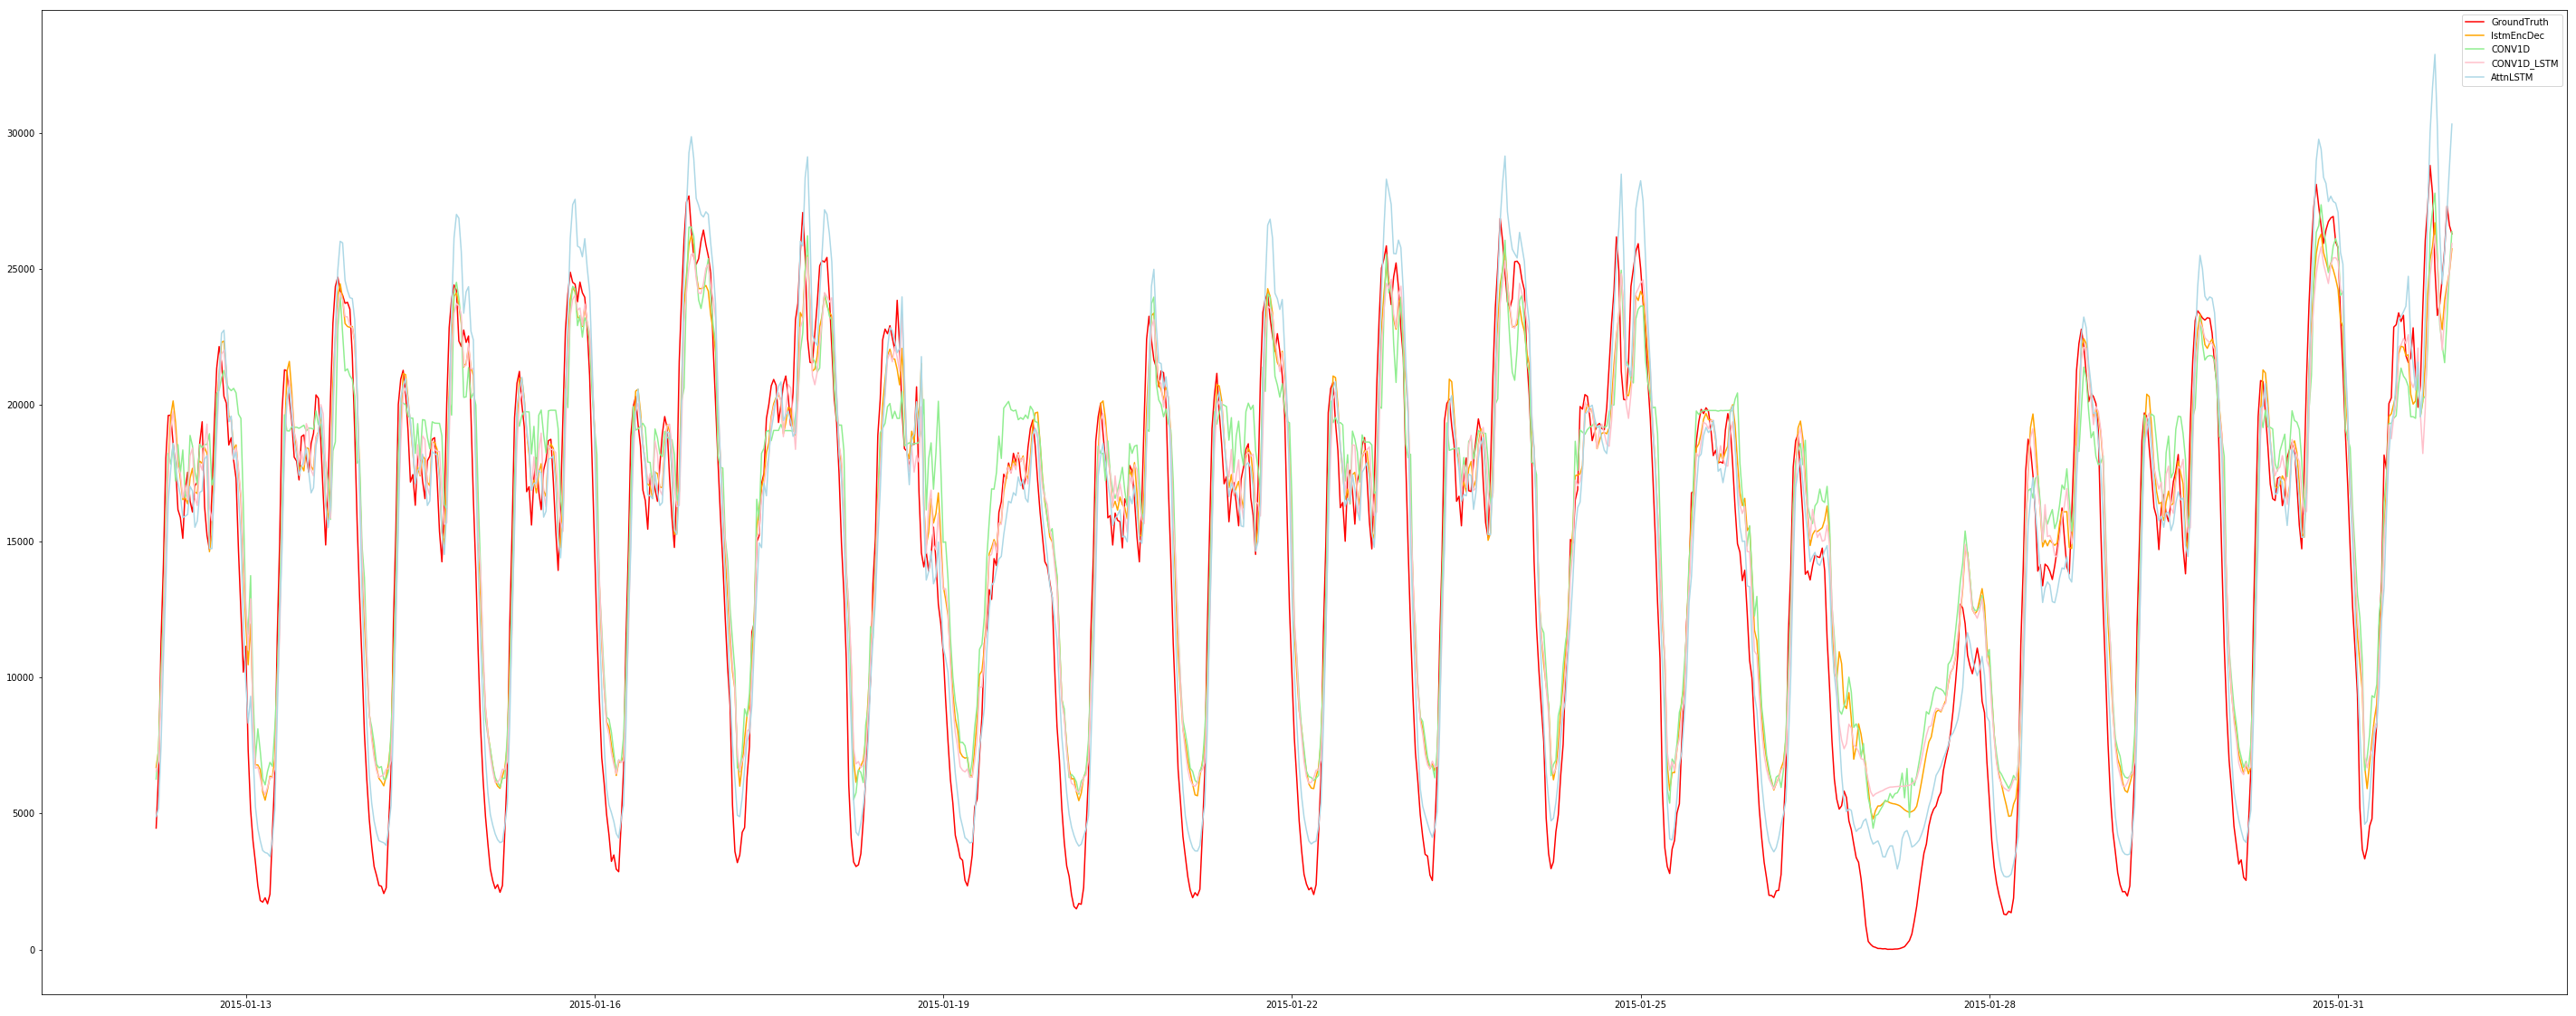

In [73]:
real_know_case = {'nyc_taxi_point':
                     ['2014-11-01 19:00:00',
                      '2014-11-27 15:30:00',
                      '2014-12-25 15:00:00',
                      '2015-01-01 01:00:00',
                      '2015-01-27 00:00:00'],
                  'nyc_taxi_window':[
                     ["2014-10-30 15:30:00.000000",
                       "2014-11-03 22:30:00.000000"],
                     ["2014-11-25 12:00:00.000000",
                      "2014-11-29 19:00:00.000000"],
                     ["2014-12-23 11:30:00.000000",
                      "2014-12-27 18:30:00.000000"],
                     ["2014-12-29 21:30:00.000000",
                      "2015-01-03 04:30:00.000000"],
                     ["2015-01-24 20:30:00.000000",
                      "2015-01-29 03:30:00.000000"]
                  ]}

plt.figure(figsize=(50,20))
plt.plot(time,ground_truth,label='GroundTruth',c='r')
plt.plot(time,lstmEncDec,label='lstmEncDec',c='orange')
plt.plot(time,conv1d,label='CONV1D',c='lightgreen')
plt.plot(time,conv1d_lstm,label='CONV1D_LSTM',c='pink')
plt.plot(time,attnLSTM,label='AttnLSTM',c='lightblue')
plt.legend()
plt.show()

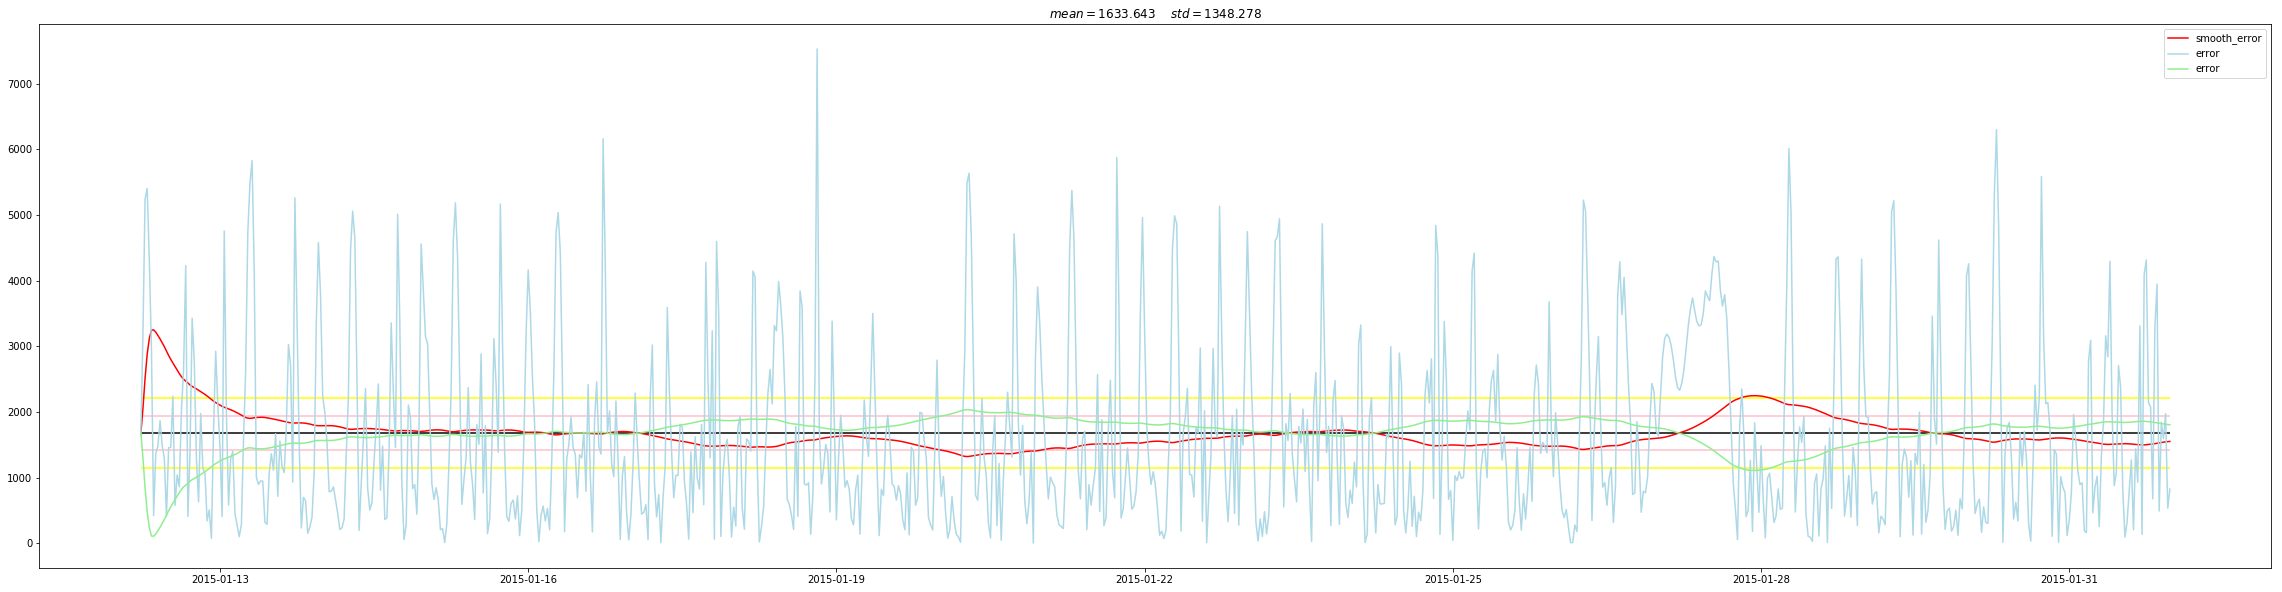

In [571]:
e = np.abs(ground_truth-attnLSTM.reshape(-1))
es = pd.DataFrame(e).ewm(span=60).mean().values.flatten().tolist()
es = pd.DataFrame(es).ewm(span=60).mean().values.flatten().tolist()
mean,std = np.mean(es),np.std(es)
es_inv = mean + mean - np.array(es)
plt.figure(figsize=(40,10))
# plt.plot(range(len(ground_truth)),ground_truth,label='GroundTruth',c='pink')
plt.plot(time,es,label='smooth_error',c='r')
plt.plot(time,e,label='error',c='lightblue')
plt.plot(time,es_inv,label='error',c='lightgreen')
plt.hlines(mean,time[0],time[-1])
plt.hlines(mean+std,time[0],time[-1],color='pink')
plt.hlines(mean-std,time[0],time[-1],color='pink')
plt.hlines(mean+2*std,time[0],time[-1],color='yellow')
plt.hlines(mean-2*std,time[0],time[-1],color='yellow')
plt.legend()
plt.title('$mean = %.3f$    $std = %.3f$'%(np.mean(e),np.std(e)))
plt.show()

In [197]:
def find_epsilon(e_s,r,limit):

    mean,std,temp = np.mean(e_s),np.std(e_s),0
    threshold = limit

    for sigma in np.arange(.1,threshold,0.05):
        epsilon = mean + std * sigma
        '''
        记录正常点的value和index
        记录异常点的index
        '''
        normal_val,normal_idx,anomaly_idx = [],[],[]

        for idx,error in enumerate(e_s):
            # 小于阈值不认为是异常
            if error < epsilon:
                normal_val.append(error);normal_idx.append(idx)
            # 大于等于阈值定异常点
            if error > epsilon:
                for area in range(0,r):
                    if idx + area not in anomaly_idx and not idx + area >= len(e_s):
                        anomaly_idx.append(idx+area)
                    if idx - area not in anomaly_idx and not idx - area <= 0:
                        anomaly_idx.append(idx+area)
        # 非空异常集合
        if len(anomaly_idx) > 0:
            anomaly_idx = sorted(list(set(anomaly_idx)))
            errorGroups = [list(errorGroup) for errorGroup in consecutive_groups(anomaly_idx)]
            startAndEnds = [(group[0],group[1]) for group in errorGroups if not group[0] == group[1]]

            mean_decrease = (mean - np.mean(normal_val)) / len(e_s)
            std_decrease = (std - np.std(normal_val)) / len(e_s)

            metric = (mean_decrease + std_decrease) / (len(startAndEnds)**2 + len(anomaly_idx))

            '''
            1.是否需要进行Error window个数制约
            2.异常值数量制约
            '''
            window_limit = 10
            if metric > temp and len(anomaly_idx) < len(e_s)*0.5 and len(startAndEnds) <= window_limit:
                threshold = sigma
                temp = metric
    
    return threshold

threshold = find_epsilon(es,50,3)
threshold_inv = find_epsilon(es,50,3)
epsilon = mean + threshold*std
epsilon_inv = mean + threshold_inv*std

In [196]:
print('>>> threshold:',threshold)
print('>>> threshold_inv:',threshold_inv)
print('>>> epsilon:',epsilon)
print('>>> epsilon_inv:',epsilon_inv)
print('>>> error_smoothed std :',std)
print('>>> error_smoothed mean:',mean)
print('>>> y_test std         :',np.std(ground_truth))

>>> threshold: 1.7500000000000007
>>> threshold_inv: 1.7500000000000007
>>> epsilon: 2045.1695555096696
>>> epsilon_inv: 2045.1695555096696
>>> error_smoothed std : 193.29896669837655
>>> error_smoothed mean: 1706.8963637875106
>>> y_test std         : 7457.433276517289


In [186]:
def compare_to_epsilon(e_s,epsilon,inter_range,y_test_std,std,r,window):
    '''
    error与epsilon的关系判断是否outlier; window:处理的error_window个数
    '''
    anomaly_idx,error_seq,non_anomaly_max = [],[],0
    '''
    std : 193.29
    mean: 1706.89
    y_test std: 7457.43
    0.05y_test_std: 372.871
    0.05inter_range: 1028.31
    '''
    #没异常的情况
#     if not (std > 0.05 * y_test_std) or max(e_s) > 0.05 * inter_range or max(e_s) <= 0.05:
#         print('====')
#         return error_seq,anomaly_idx,non_anomaly_max
        

    window_size = 50
    num_to_ignore = window_size * 2
    for idx in range(len(e_s)):
        anom_flag = True
        if e_s[idx] <= epsilon or e_s[idx] < 0.05 * inter_range:
            anom_flag = False
        if anom_flag:
            for area in range(0,r):
                '''
                1.当前点未存
                2.当前点没出边界
                3.到最后一个窗口没找到异常
                '''
                if idx + area not in anomaly_idx and 0 < idx + area < len(e_s) and (idx + area >= len(e_s) - window_size or window == 0):
                    anomaly_idx.append(idx + area)
                if idx - area not in anomaly_idx and (idx - area >= len(e_s) - window_size or window == 0):
                    if not (window == 0 and idx - area < num_to_ignore):
                        anomaly_idx.append(idx - area)
    # 非异常的最大值
    min_anom = min(np.array(e_s)[anomaly_idx])
    for idx in range(0,len(e_s)):
        temp = e_s[idx]
        if temp < min_anom and temp > non_anomaly_max:
            non_anomaly_max = temp

    anomaly_idx = sorted(list(set(anomaly_idx)))
    startAndEnds = [list(startAndEnd) for startAndEnd in consecutive_groups(anomaly_idx)]
    error_seq = [(group[0],group[-1]) for group in startAndEnds if group[0] != group[1]]    
    return error_seq,anomaly_idx,non_anomaly_max


In [187]:
perc_high,perc_low = np.percentile(ground_truth,[90,10])
inter_range = perc_high - perc_low
y_test_std = np.std(ground_truth)

In [279]:
error_seq,anomaly_idx,non_anomaly_max = compare_to_epsilon(es,epsilon,inter_range,y_test_std,std,50,0)
error_seq_inv,anomaly_idx_inv,non_anomaly_maxinv = compare_to_epsilon(es_inv,epsilon_inv,inter_range,y_test_std,std,50,0)

In [221]:
error_seq_max,e_s_max,e_s_max_idx = [],[],[]

In [222]:
for seq in error_seq:
    start,end = seq[0],seq[1]
    point = es[start:end].index(max(es[start:end]))+start
    print(point)
    error_seq_max.append(max(es[start:end]))
    e_s_max.append(max(es[start:end]))
print(e_s_max)

5
726
[2846.77803206195, 2457.0196006345714]


In [283]:
def prune_anoms(error_seq,e_s,non_anomaly_max,anomaly_idx):
    error_seq_max,e_s_max,e_s_max_idx = [],[],[]
    for seq in error_seq:
        if len(e_s[seq[0]:seq[1]]) > 0:
            start,end = seq[0],seq[1]
            error_seq_max.append(max(e_s[start:end]))
            e_s_max.append(max(e_s[start:end]))

    e_s_max.append(non_anomaly_max)
    e_s_max.sort(reverse = True)

    remove_idx = []
    decay = 0.13

    for idx in range(0,len(e_s_max)):
        if idx+1 < len(e_s_max):
            if (e_s_max[idx] - e_s_max[idx+1]) / e_s_max[idx] < decay:
                remove_idx.append(error_seq_max.index(e_s_max[idx]))
            else:
                remove_idx = []

    for idx in sorted(remove_idx,reverse=True):
        del error_seq[idx]

    pruned_idx = []
    for idx in anomaly_idx:
        keep_anomaly = False
        for seq in error_seq:
            if idx >= seq[0] and idx<=seq[1]:
                keep_anomaly = True
        
        if keep_anomaly == True:
            pruned_idx.append(idx)
            
    return pruned_idx

In [284]:
anomaly_idx = prune_anoms(error_seq,es,non_anomaly_max,anomaly_idx)

In [287]:
anomaly_idx_inv = prune_anoms(error_seq_inv,es_inv,non_anomaly_maxinv,anomaly_idx_inv)

In [681]:
anomaly_idx_attn = np.load('./anomaly_idx_attn.npy')
anomaly_idx_lstm = np.load('./anomaly_idx_LSTMEncDec.npy')
anomaly_idx_conv = np.load('./anomaly_idx_conv1d.npy')
anomaly_idx_conv_lstm = np.load('./anomaly_idx_conv1dLSTM.npy')

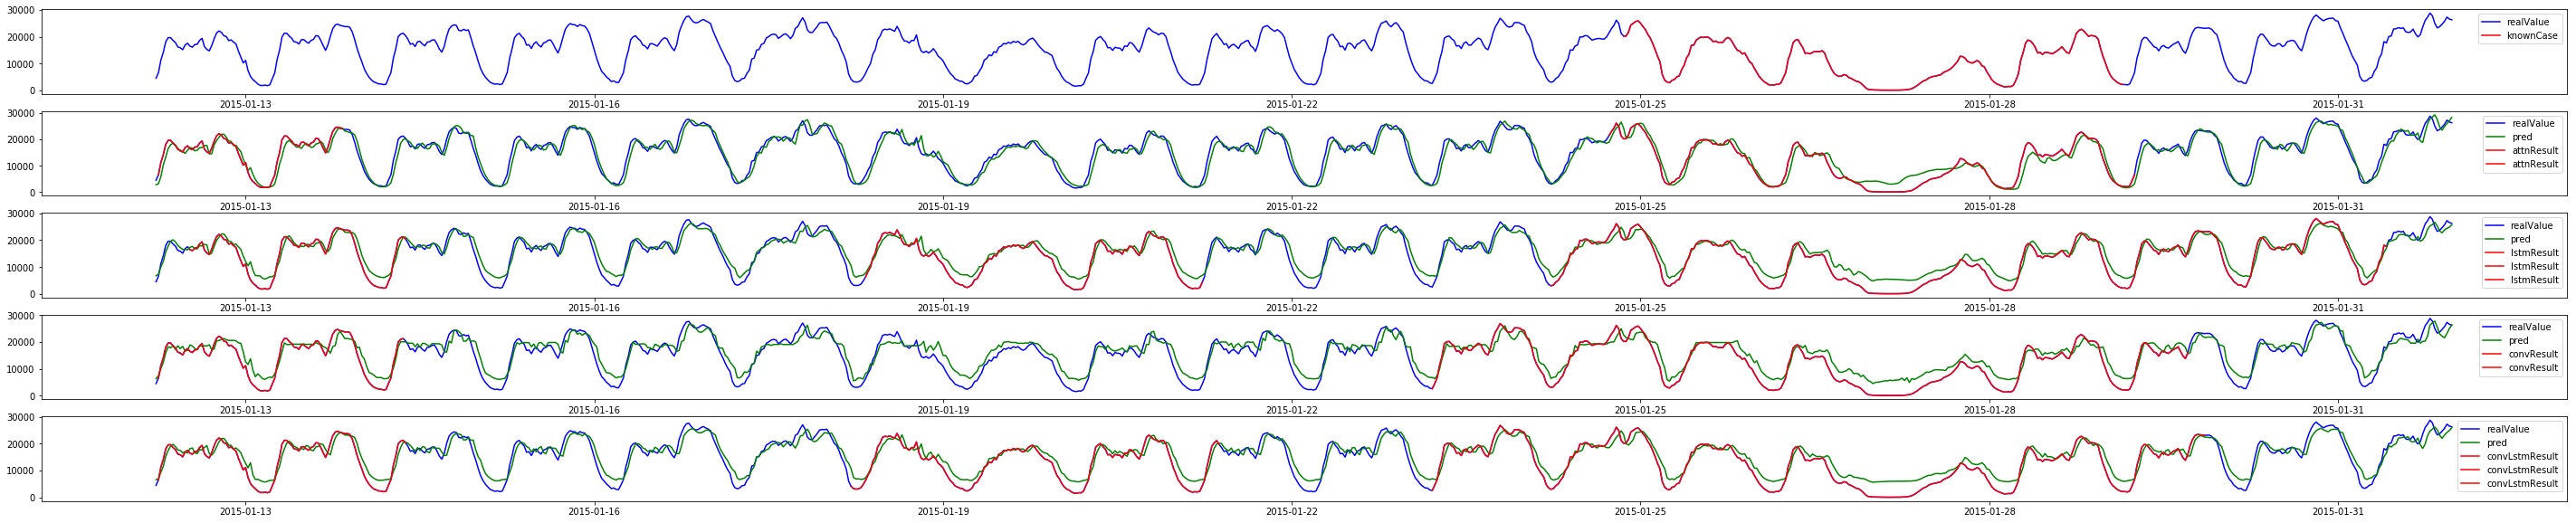

In [682]:
wrong = ["2015-01-24 20:30:00.00",
         "2015-01-29 03:30:00.00"]
wrong = pd.to_datetime(wrong)
real_idx = []
for i,j in enumerate(time):
    if j in wrong:
        real_idx.append(i)
anomaly_idxs = [anomaly_idx_attn,anomaly_idx_lstm,anomaly_idx_conv,anomaly_idx_conv_lstm]
anomaly_name = ['attnResult','lstmResult','convResult','convLstmResult']
predict_values = [attnLSTM,lstmEncDec,conv1d,conv1d_lstm]
plt.figure(figsize=(50,10))
plt.subplot(511)
plt.plot(time,ground_truth,c='blue',label='realValue')
plt.plot(time[real_idx[0]:real_idx[1]+1],ground_truth[real_idx[0]:real_idx[1]+1],c='red',label='knownCase')
plt.legend()
for pic_num,anomaly_idx in enumerate(anomaly_idxs):
    plt.subplot(512+pic_num)
    plt.plot(time,ground_truth,c='blue',label='realValue')
    plt.plot(time,predict_values[pic_num],c='green',label='pred')
    groups = []
    for group in consecutive_groups(anomaly_idx):
        groups.append(list(group))
    for i in range(len(groups)):
        plt.plot(time[groups[i]],ground_truth[groups[i]],c='red',label=anomaly_name[pic_num])
    plt.legend()
plt.show()

In [677]:
df = pd.read_csv('./results.csv')
attnNew = np.load('./AttnBi-LSTM.npy')
def precess(attn):
    data = pd.read_csv('../data/nyc_taxi.csv')
    data = data['value'].values
    min_num = np.array([min(data)])
    max_num = np.array([max(data)])
    interval = (max_num-min_num) / 2
    mean = (max_num+min_num) / 2
    attn = attn * interval + mean
    return attn
attnLSTM = precess(attnNew)
df['AttnLSTM'] = attnLSTM
del df['attnLSTM']
df.to_csv('./results.csv',index=0)

In [678]:
df

,ground_truth,LSTM-Enc-Dnc,CONV1D-DENSE,CONV1D-LSTM,AttnLSTM
0,4462,6685.537897,6260.405672,6548.526489,2771.272450
1,6496,7324.311307,7415.911525,6916.499384,3114.929183
2,11269,9995.006572,10064.984443,9375.103881,5815.502844
3,14140,12066.283351,12362.748395,11564.421491,10294.654207
4,18040,15696.486806,15934.314806,15256.564878,13226.474327
5,19618,17770.627917,18224.878219,17445.773287,16455.274254
6,19631,19597.712920,17827.681258,19116.703508,17885.403673
7,18598,20151.613697,18562.104002,19769.504844,18606.445521
8,17797,19368.009761,17213.059040,18904.545439,17546.013363
9,16160,18047.977854,18547.157432,17735.809498,16671.900067


In [670]:
pd.read_csv('./results.csv').head()

,ground_truth,LSTM-Enc-Dnc,CONV1D-DENSE,CONV1D-LSTM,AttnLSTM,attnLSTM
0,4462,6685.537897,6260.405672,6548.526489,2802.778347,2771.272450
1,6496,7324.311307,7415.911525,6916.499384,3329.843405,3114.929183
2,11269,9995.006572,10064.984443,9375.103881,6028.695547,5815.502844
3,14140,12066.283351,12362.748395,11564.421491,8734.202515,10294.654207
4,18040,15696.486806,15934.314806,15256.564878,13740.372804,13226.474327


In [671]:
print('>>> LSTM-Enc-Dnc %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,lstmEncDec)),r2_score(ground_truth,lstmEncDec)))
print('>>> CONV1D-DENSE %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,conv1d)),r2_score(ground_truth,conv1d)))
print('>>> CONV1D-LSTM  %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,conv1d_lstm)),r2_score(ground_truth,conv1d_lstm)))
print('>>> AttnLSTM     %.3f(RMSE) %.3f(R^2)'%(np.sqrt(mean_squared_error(ground_truth,attnLSTM)),r2_score(ground_truth,attnLSTM)))

>>> LSTM-Enc-Dnc 2605.034(RMSE) 0.878(R^2)
>>> CONV1D-DENSE 3051.177(RMSE) 0.833(R^2)
>>> CONV1D-LSTM  2768.831(RMSE) 0.862(R^2)
>>> AttnLSTM     2100.018(RMSE) 0.921(R^2)


In [647]:
from more_itertools import consecutive_groups
import pandas as pd

def calcScore(anomalyList):
    label = ["2015-01-24 20:30:00.000000",
            "2015-01-29 03:30:00.000000"]
    label = pd.to_datetime(label)
    time = pd.read_csv('../data/nyc_taxi_test.csv')['1'][-(1000 - 50 - 1):].values
    time = pd.to_datetime(time.tolist())
    
    time_idx = []
    for tid,t in enumerate(time):
        if label[0] <= t <= label[1]:
            time_idx.append(tid)
    ground_truth = [list(g) for g in consecutive_groups(time_idx)]
    ground_truth = [[g[0],g[-1]] for g in ground_truth]
    # 初始化统计
    # every point in a window is a false negative
    # every point outside a window is a true negtive

    anom = {}
    anom['false_positives'] = 0
    anom['false_negatives'] = 0
    anom['true_positives'] = 0
    anom['fp_sequences'] = []
    anom['tp_sequences'] = []
    anom['num_anoms'] = len(ground_truth)
    
    startAndEnds = [list(g) for g in consecutive_groups(anomalyList)]
    startAndEnds = [[g[0],g[-1]] for g in startAndEnds]
    error_sequence = [(group[0],group[1]) for group in startAndEnds if group[0] != group[1]]
    if len(error_sequence) > 0:
        matched_error_sequence_test = []
        for startEnd in error_sequence:
            valid = False
            for idx,a in enumerate(ground_truth):
                condition1 = (startEnd[0] >= a[0] and startEnd[0] <= a[1]) # 异常区间的开始点在标准区间内
                condition2 = (startEnd[1] >= a[0] and startEnd[1] <= a[1]) # 异常区间在结束点在标准区间内
                condition3 = (startEnd[0] <= a[0] and startEnd[1] >= a[1]) # 标准区间在异常区间内
                condition4 = (a[0] <= startEnd[0] and a[1] >= startEnd[1])  # 异常区间在标准区间内
                if  condition1 or condition2 or condition3 or condition4:
                    anom['tp_sequences'].append(startEnd)
                    valid = True

                    if idx not in matched_error_sequence_test:
                        anom['true_positives'] += 1
                        matched_error_sequence_test.append(idx)

            if valid == False:
                anom['false_positives'] += 1
                anom['fp_sequences'].append([startEnd[0],startEnd[1]])

        anom['false_negatives'] += len(ground_truth) - len(matched_error_sequence_test)

    else:
        anom['false_negatives'] += len(ground_truth)

    return anom

In [648]:
from pprint import pprint
print('>>> Attn:')
pprint(calcScore(anomaly_idx_attn))
print('>>> conv:')
pprint(calcScore(anomaly_idx_conv))

>>> Attn:
{'false_negatives': 0,
 'false_positives': 2,
 'fp_sequences': [[1, 72], [319, 444]],
 'num_anoms': 1,
 'tp_sequences': [(663, 815)],
 'true_positives': 1}
>>> conv:
{'false_negatives': 0,
 'false_positives': 1,
 'fp_sequences': [[1, 90]],
 'num_anoms': 1,
 'tp_sequences': [(646, 832)],
 'true_positives': 1}


In [584]:
label = ["2015-01-24 20:30:00.000000",
        "2015-01-29 03:30:00.000000"]
label = pd.to_datetime(label)
for t in time:
    if label[0]<=t<=label[1]:
        print(t)

2015-01-24 20:30:00
2015-01-24 21:00:00
2015-01-24 21:30:00
2015-01-24 22:00:00
2015-01-24 22:30:00
2015-01-24 23:00:00
2015-01-24 23:30:00
2015-01-25 00:00:00
2015-01-25 00:30:00
2015-01-25 01:00:00
2015-01-25 01:30:00
2015-01-25 02:00:00
2015-01-25 02:30:00
2015-01-25 03:00:00
2015-01-25 03:30:00
2015-01-25 04:00:00
2015-01-25 04:30:00
2015-01-25 05:00:00
2015-01-25 05:30:00
2015-01-25 06:00:00
2015-01-25 06:30:00
2015-01-25 07:00:00
2015-01-25 07:30:00
2015-01-25 08:00:00
2015-01-25 08:30:00
2015-01-25 09:00:00
2015-01-25 09:30:00
2015-01-25 10:00:00
2015-01-25 10:30:00
2015-01-25 11:00:00
2015-01-25 11:30:00
2015-01-25 12:00:00
2015-01-25 12:30:00
2015-01-25 13:00:00
2015-01-25 13:30:00
2015-01-25 14:00:00
2015-01-25 14:30:00
2015-01-25 15:00:00
2015-01-25 15:30:00
2015-01-25 16:00:00
2015-01-25 16:30:00
2015-01-25 17:00:00
2015-01-25 17:30:00
2015-01-25 18:00:00
2015-01-25 18:30:00
2015-01-25 19:00:00
2015-01-25 19:30:00
2015-01-25 20:00:00
2015-01-25 20:30:00
2015-01-25 21:00:00


In [637]:
g = [list(g) for g in consecutive_groups([1,2,3,4,5,8,9,10])]
g = [[gg[0],gg[-1]] for gg in g]

In [638]:
g

[[1, 5], [8, 10]]